# Movie Reviews Sentiment Analysis and Model Deployment

### Dataset

This dataset can be found on Kaggle.

The dataset is comprised of tab-separated files with phrases from the Rotten Tomatoes dataset. The train/test split has been preserved for the purposes of benchmarking, but the sentences have been shuffled from their original order. Each Sentence has been parsed into many phrases by the Stanford parser. Each phrase has a PhraseId. Each sentence has a SentenceId. Phrases that are repeated (such as short/common words) are only included once in the data.

train.tsv contains the phrases and their associated sentiment labels. We have additionally provided a SentenceId so that you can track which phrases belong to a single sentence.
test.tsv contains just phrases. You must assign a sentiment label to each phrase.
The sentiment labels are:

- 0 - negative
- 1 - somewhat negative
- 2 - neutral
- 3 - somewhat positive
- 4 - positive

### Objective

The purpose of this notebook is to build a model which can be deployed later.


### Libraries

In [1]:
# Lets import all libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.compose import ColumnTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline,FeatureUnion
from sklearn.externals import joblib

from sklearn.model_selection import train_test_split


import warnings
import os
import seaborn as sns
import chart_studio.plotly as py
import plotly.graph_objs as go
import plotly.io as pio
from plotly.offline import plot , iplot ,init_notebook_mode
init_notebook_mode(connected=True)
%matplotlib inline

warnings.filterwarnings('ignore')

C:\Users\i323570\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


### Load Data

In [2]:
# Check for available files
for file in os.listdir('./data'):
    print('Filename: {0} --> {1}'.format(file.ljust(30).rstrip(),
                                       str(round(os.path.getsize('./data/'+file)/1000000,2))+' MB'))

Filename: test.tsv --> 3.37 MB
Filename: train.tsv --> 8.48 MB


In [3]:
# Read the data
reviews_orig = pd.read_csv('./data/train.tsv',sep = '\t')
reviews_orig.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


### Quick EDA

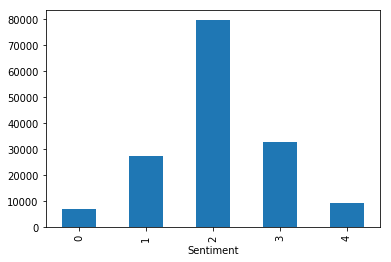

In [4]:
# Check the balance of the class labels
reviews_orig.groupby('Sentiment')['PhraseId'].count().plot.bar()

We have a lot of review with Neutral Sentiment, which does not help for predictions. So let's remove them.

In [5]:
reviews_pos_neg =  reviews_orig[reviews_orig.Sentiment != 2]
reviews_pos_neg.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
21,22,1,good for the goose,3
22,23,1,good,3
33,34,1,"the gander , some of which occasionally amuses...",1
46,47,1,amuses,3


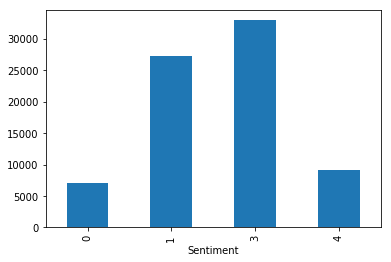

In [6]:
# Now let's check the balance
reviews_pos_neg.groupby('Sentiment')['PhraseId'].count().plot.bar()

In [7]:
# Check for NaN values
reviews_pos_neg.isnull().sum()

PhraseId      0
SentenceId    0
Phrase        0
Sentiment     0
dtype: int64

In [8]:
reviews_pos_neg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76478 entries, 0 to 156057
Data columns (total 4 columns):
PhraseId      76478 non-null int64
SentenceId    76478 non-null int64
Phrase        76478 non-null object
Sentiment     76478 non-null int64
dtypes: int64(3), object(1)
memory usage: 2.9+ MB


For the sake of brevity let's only take the most extreme rewviews i.e. 0 / 4

In [9]:
reviews_extreme = reviews_pos_neg[(reviews_pos_neg.Sentiment == 0) | ( reviews_pos_neg.Sentiment == 4)]
reviews_extreme.sample(5)

,PhraseId,SentenceId,Phrase,Sentiment
76552,76553,3937,'s been done before but never so vividly or wi...,4
80502,80503,4146,"A dark , quirky road movie that constantly def...",4
41535,41536,2000,"comes along only occasionally , one so unconve...",4
148762,148763,8093,A modestly made but profoundly moving documentary,4
118201,118202,6313,"the most creative , energetic and original com...",4


In [10]:
reviews_extreme['binary_sentiment'] = reviews_extreme.apply(lambda x : 0 if x.Sentiment==0 else 1,axis = 1)

In [11]:
reviews_extreme.head()

,PhraseId,SentenceId,Phrase,Sentiment,binary_sentiment
63,64,2,"This quiet , introspective and entertaining in...",4,1
66,67,2,"quiet , introspective and entertaining indepen...",4,1
74,75,2,entertaining,4,1
77,78,2,is worth seeking,4,1
101,102,3,would have a hard time sitting through this one,0,0


### Create a reusable pipeline for text preprocessing

Found a detailed article for building Custom NLP Transformer Based Pipelines
credits : https://towardsdatascience.com/text-preprocessing-steps-and-universal-pipeline-94233cb6725a



In [12]:
from sklearn.base import TransformerMixin,BaseEstimator
import bs4
import string
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

class TextPreprocessor(BaseEstimator,TransformerMixin):
    def __init__(self):
        """ Text preprocessing transformer includes steps:
            1. Punctuation removal
            2. Stop words removal
            3. Stemming
            4. HTML removal
            """
        self._cached_stop_words = stopwords.words('english') # Provides 70 X Speedup
        self._stemmer = PorterStemmer()
        self._punctuations = set(string.punctuation)
        self._tokenizer = RegexpTokenizer(r'\w+')
        self._bs = bs4
        
    def fit(self, df,y=None):
        return self 
    
    def transform(self,df,y=None):
        df['new_phrase'] = self._remove_html(df['Phrase'])
        df['new_phrase'] = df['new_phrase'].apply(lambda x : self._tokenizer.tokenize(x.lower()))
        df['new_phrase'] = df['new_phrase'].apply(lambda x : self._stop_word_removal(x))
        df['new_phrase'] = df['new_phrase'].apply(lambda x : self._helper_remove_punctuations(x))
        df['new_phrase'] = df['new_phrase'].apply(lambda x : self._word_stemmer(x))
        return df
        
    def _stop_word_removal(self,phrases):
        words = [word for word in phrases if \
             word not in self._cached_stop_words]
        return words

    def _word_stemmer(self,text):
        stemmed_text = " ".join(self._stemmer.stem(word) for word in text)
        return stemmed_text
    
    def _remove_html(self,phrases):
        html_free_text = [self._bs.BeautifulSoup(x).get_text() for x in phrases] 
        return html_free_text
    
    def _helper_remove_punctuations(self,phrases):
         punctuation_free_text = [char for char in phrases if char \
                                    not in self._punctuations]
         return punctuation_free_text

In [13]:
class TextSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on text columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]

In [14]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer

text_pipeline = Pipeline(steps=[
                                ('preproc',TextPreprocessor()),
                                ('textselector',TextSelector(key = 'new_phrase')),
                                ('BOW',CountVectorizer(ngram_range=(1,4))),
                                ('tfidf',TfidfTransformer())
                                ])

In [15]:
text = text_pipeline.fit_transform(reviews_extreme)

In [16]:
from sklearn.ensemble import RandomForestClassifier

features = Pipeline([
                        ('text',text_pipeline),
                        ('classifier',RandomForestClassifier())
                        ])

In [17]:
X_train, X_test, y_train, y_test = train_test_split(reviews_extreme.drop('binary_sentiment',axis =1),reviews_extreme.binary_sentiment, test_size=0.33, random_state=42)

In [18]:
trans = features.fit(X_train,y_train)

HOW TO SAVE PIPELINE :
https://stackoverflow.com/questions/47416982/load-and-predict-new-data-sklearn

https://towardsdatascience.com/custom-transformers-and-ml-data-pipelines-with-python-20ea2a7adb65

https://www.kaggle.com/harshitmakkar/sentiment-analysis-on-movie-reviews-nlp
All the data preparation steps should be fit using train data. Otherwise, you risk applying the wrong transformations, because means and variances that StandardScaler estimates do probably differ between train and test data.

The easiest way to train, save, load and apply all the steps simultaneously is to use Pipelines:

At training:

# prepare the pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.externals import joblib

pipe = make_pipeline(StandardScaler(), LogisticRegression)
pipe.fit(X_train, y_train)
joblib.dump(pipe, 'model.pkl')
At prediction:

#Loading the saved model with joblib
pipe = joblib.load('model.pkl')

# New data to predict
pr = pd.read_csv('set_to_predict.csv')
pred_cols = list(pr.columns.values)[:-1]

# apply the whole pipeline to data
pred = pd.Series(pipe.predict(pr[pred_cols]))
print pred

In [19]:
test_data = pd.read_csv('./data/test.tsv',sep = '\t')
test_data.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


In [20]:
preds = trans.predict(X_test)
np.mean(preds == y_test)

0.907855547282204

#### Wow 90 % on the test set without any Hyperparameter Tuning is great !

In [21]:
new_data_testing = pd.DataFrame.from_dict({'Phrase':['the movie was terrible and was a waste of time']})
new_data_prediction = trans.predict(new_data_testing)
print(new_data_prediction)

[0]


Predicted : Negative

In [22]:
new_data_testing = pd.DataFrame.from_dict({'Phrase':['Aquaman was a great movie and the writing was clever, the direction was great']})
new_data_prediction = trans.predict(new_data_testing)
print(new_data_prediction)

[1]


Predicted : Positive

In [23]:
new_data_testing = pd.DataFrame.from_dict({'Phrase':['''If you are a preteen, the story may work for you. If you have any common sense, the bad dialogue and blatant rip off of every sci-fi and fantasy movie cliche will drive you crazy.

Special effects are decent, and the story moves along at a decent pace. Momoa carries the film despite being surrounded by one dimensional characters with digitally botoxed faces. I would never watch this movie again.''']})
new_data_prediction = trans.predict(new_data_testing)
print(new_data_prediction)

[0]


Predicted : Negative

Actual https://www.imdb.com/review/rw4583916/?ref_=tt_urv

In [24]:
new_data_testing = pd.DataFrame.from_dict({'Phrase':['''We know that the DC cinematic universe that emerged as a result of the partnership between DC Comics and Warner Bros does not go well. Aquaman does not fall into this category. The film first appeared in China. Then the comments about the movie excited me. I was looking forward to it. It was a movie I really liked.

The story of the film is a complete story of origin. We see how a character emerged and how he was a hero. We see what Arthur Curry has been going through since his birth. I mean, you can follow the course of the story very easily and there is no scene you will be surprised. From time to time clichés and boring moments can be experienced. When you think it's a story of beginnings, the cliches don't bother you much. I think this is a must for superhero films.

While watching Aquaman, you feel a lot more of Wan's touch to the film. Aquaman literally makes you feel like a "movie". Because while watching the film, you can see the introduction, development and the result line in a very comfortable way. Everything is as it should be. The characters perform their duties more than enough. In the first 20 minutes, you already feel inside the film, and your attachment instinct confirms this. The origin of Aquaman is generally preserved. There are some minor changes to the film. At the same time, there are critical changes in the Black Manta and Orm. But if you are a comic book reader in general, Arthur Curry's story will give you pleasure. The film also touches on a beautiful subject; People pollute the oceans and nature. Jason Momoa had a successful performance. In particular, he has reflected the character change very well. Willem Dafoe is an actor that everyone will enjoy watching. Willem Dafoe had to have more scenes.

The film has technical errors, logic errors, clichés. But in spite of all this, the good aspects are much more. James Wan really created a separate world for the film. The underwater scenes were very good. The visuality is tremendous. Sea creatures, underwater conversations, used camera angles, location preferences, costume designs, fighting scenes, visual effects were very good. The music was just as good as the visuals. Even a separate film for Atlantis can be shot. 8/10
''']})
new_data_prediction = trans.predict(new_data_testing)
print(new_data_prediction)

[1]


Predicted : Positive

Actual : https://www.imdb.com/review/rw4547407/?ref_=tt_urv

### Saving the Pipline for Deployment

In [29]:
import dill as pickle
filename = 'model.pkl'
with open('./model/'+filename, 'wb') as file:
    pickle.dump(trans, file) 

In [30]:
with open('./model/'+filename ,'rb') as f:
    loaded_model = pickle.load(f)

In [31]:
new_data_testing = pd.DataFrame.from_dict({'Phrase':['Aquaman was a great movie and the writing was clever, the direction was great']})
new_data_prediction = loaded_model.predict(new_data_testing)
print(new_data_prediction[0])

1
